# Artificial Intelligence Engineer Nanodegree - Probabilistic Models
## Project: Sign Language Recognition System
- [Introduction](#intro)
- [Part 1 Feature Selection](#part1_tutorial)
    - [Tutorial](#part1_tutorial)
    - [Features Submission](#part1_submission)
    - [Features Unittest](#part1_test)
- [Part 2 Train the models](#part2_tutorial)
    - [Tutorial](#part2_tutorial)
    - [Model Selection Score Submission](#part2_submission)
    - [Model Score Unittest](#part2_test)
- [Part 3 Build a Recognizer](#part3_tutorial)
    - [Tutorial](#part3_tutorial)
    - [Recognizer Submission](#part3_submission)
    - [Recognizer Unittest](#part3_test)
- [Part 4 (OPTIONAL) Improve the WER with Language Models](#part4_info)

<a id='intro'></a>
## Introduction
The overall goal of this project is to build a word recognizer for American Sign Language video sequences, demonstrating the power of probabalistic models.  In particular, this project employs  [hidden Markov models (HMM's)](https://en.wikipedia.org/wiki/Hidden_Markov_model) to analyze a series of measurements taken from videos of American Sign Language (ASL) collected for research (see the [RWTH-BOSTON-104 Database](http://www-i6.informatik.rwth-aachen.de/~dreuw/database-rwth-boston-104.php)).  In this video, the right-hand x and y locations are plotted as the speaker signs the sentence.
[![ASLR demo](http://www-i6.informatik.rwth-aachen.de/~dreuw/images/demosample.png)](https://drive.google.com/open?id=0B_5qGuFe-wbhUXRuVnNZVnMtam8)

The raw data, train, and test sets are pre-defined.  You will derive a variety of feature sets (explored in Part 1), as well as implement three different model selection criterion to determine the optimal number of hidden states for each word model (explored in Part 2). Finally, in Part 3 you will implement the recognizer and compare the effects the different combinations of feature sets and model selection criteria.  

At the end of each Part, complete the submission cells with implementations, answer all questions, and pass the unit tests.  Then submit the completed notebook for review!

<a id='part1_tutorial'></a>
## PART 1: Data

### Features Tutorial
##### Load the initial database
A data handler designed for this database is provided in the student codebase as the `AslDb` class in the `asl_data` module.  This handler creates the initial [pandas](http://pandas.pydata.org/pandas-docs/stable/) dataframe from the corpus of data included in the `data` directory as well as dictionaries suitable for extracting data in a format friendly to the [hmmlearn](https://hmmlearn.readthedocs.io/en/latest/) library.  We'll use those to create models in Part 2.

To start, let's set up the initial database and select an example set of features for the training set.  At the end of Part 1, you will create additional feature sets for experimentation. 

In [70]:
import numpy as np
import pandas as pd
from asl_data import AslDb

feature_sets = dict()
asl = AslDb() # initializes the database
asl.df.head() # displays the first five rows of the asl database, indexed by video and frame

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker
video frame                                                           
98    0         149     181      170      175     161      62  woman-1
      1         149     181      170      175     161      62  woman-1
      2         149     181      170      175     161      62  woman-1
      3         149     181      170      175     161      62  woman-1
      4         149     181      170      175     161      62  woman-1

In [71]:
asl.df.ix[98,1]  # look at the data available for an individual frame

left-x         149
left-y         181
right-x        170
right-y        175
nose-x         161
nose-y          62
speaker    woman-1
Name: (98, 1), dtype: object

The frame represented by video 98, frame 1 is shown here:
![Video 98](http://www-i6.informatik.rwth-aachen.de/~dreuw/database/rwth-boston-104/overview/images/orig/098-start.jpg)

##### Feature selection for training the model
The objective of feature selection when training a model is to choose the most relevant variables while keeping the model as simple as possible, thus reducing training time.  We can use the raw features already provided or derive our own and add columns to the pandas dataframe `asl.df` for selection. As an example, in the next cell a feature named `'grnd-ry'` is added. This feature is the difference between the right-hand y value and the nose y value, which serves as the "ground" right y value. 

In [72]:
asl.df['grnd-ry'] = asl.df['right-y'] - asl.df['nose-y']
asl.df.head()  # the new feature 'grnd-ry' is now in the frames dictionary

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  
video frame           
98    0          113  
      1          113  
      2          113  
      3          113  
      4          113

##### Try it!

In [73]:
from asl_utils import test_features_tryit

# TODO add df columns for 'grnd-rx', 'grnd-ly', 'grnd-lx' representing differences between hand and nose locations
asl.df['grnd-rx'] = asl.df['right-x'] - asl.df['nose-x']
asl.df['grnd-ry'] = asl.df['right-y'] - asl.df['nose-y']
asl.df['grnd-ly'] = asl.df['left-y']  - asl.df['nose-y']
asl.df['grnd-lx'] = asl.df['left-x']  - asl.df['nose-x']
asl.df.head()
# test the code
test_features_tryit(asl)

asl.df sample


left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-ly  grnd-lx  
video frame                                      
98    0          113        9      119      -12  
      1          113        9      119      -12  
      2          113        9      119      -12  
      3          113        9      119      -12  
      4          113        9      119      -12

In [74]:
# collect the features into a list
features_ground = ['grnd-rx','grnd-ry','grnd-lx','grnd-ly']
feature_sets['features-ground'] = set(features_ground)

#show a single set of features for a given (video, frame) tuple
[asl.df.ix[98,1][v] for v in features_ground]

[9, 113, -12, 119]

##### Build the training set
Now that we have a feature list defined, we can pass that list to the `build_training` method to collect the features for all the words in the training set.  Each word in the training set has multiple examples from various videos.  Below we can see the unique words that have been loaded into the training set:

In [75]:
training = asl.build_training(features_ground)
print("Training words: {}".format(training.words))

Training words: ['JOHN', 'WRITE', 'HOMEWORK', 'IX-1P', 'SEE', 'YESTERDAY', 'IX', 'LOVE', 'MARY', 'CAN', 'GO', 'GO1', 'FUTURE', 'GO2', 'PARTY', 'FUTURE1', 'HIT', 'BLAME', 'FRED', 'FISH', 'WONT', 'EAT', 'BUT', 'CHICKEN', 'VEGETABLE', 'CHINA', 'PEOPLE', 'PREFER', 'BROCCOLI', 'LIKE', 'LEAVE', 'SAY', 'BUY', 'HOUSE', 'KNOW', 'CORN', 'CORN1', 'THINK', 'NOT', 'PAST', 'LIVE', 'CHICAGO', 'CAR', 'SHOULD', 'DECIDE', 'VISIT', 'MOVIE', 'WANT', 'SELL', 'TOMORROW', 'NEXT-WEEK', 'NEW-YORK', 'LAST-WEEK', 'WILL', 'FINISH', 'ANN', 'READ', 'BOOK', 'CHOCOLATE', 'FIND', 'SOMETHING-ONE', 'POSS', 'BROTHER', 'ARRIVE', 'HERE', 'GIVE', 'MAN', 'NEW', 'COAT', 'WOMAN', 'GIVE1', 'HAVE', 'FRANK', 'BREAK-DOWN', 'SEARCH-FOR', 'WHO', 'WHAT', 'LEG', 'FRIEND', 'CANDY', 'BLUE', 'SUE', 'BUY1', 'STOLEN', 'OLD', 'STUDENT', 'VIDEOTAPE', 'BORROW', 'MOTHER', 'POTATO', 'TELL', 'BILL', 'THROW', 'APPLE', 'NAME', 'SHOOT', 'SAY-1P', 'SELF', 'GROUP', 'JANA', 'TOY1', 'MANY', 'TOY', 'ALL', 'BOY', 'TEACHER', 'GIRL', 'BOX', 'GIVE2', 'GIVE3

The training data in `training` is an object of class `WordsData` defined in the `asl_data` module.  in addition to the `words` list, data can be accessed with the `get_all_sequences`, `get_all_Xlengths`, `get_word_sequences`, and `get_word_Xlengths` methods. We need the `get_word_Xlengths` method to train multiple sequences with the `hmmlearn` library.  In the following example, notice that there are two lists; the first is a concatenation of all the sequences(the X portion) and the second is a list of the sequence lengths(the Lengths portion).

In [76]:
training.get_word_Xlengths('CHOCOLATE')

(array([[-11,  48,   7, 120],
        [-11,  48,   8, 109],
        [ -8,  49,  11,  98],
        [ -7,  50,   7,  87],
        [ -4,  54,   7,  77],
        [ -4,  54,   6,  69],
        [ -4,  54,   6,  69],
        [-13,  52,   6,  69],
        [-13,  52,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [-10,  59,   7,  71],
        [-15,  64,   9,  77],
        [-17,  75,  13,  81],
        [ -4,  48,  -4, 113],
        [ -2,  53,  -4, 113],
        [ -4,  55,   2,  98],
        [ -4,  58,   2,  98],
        [ -1,  59,   2,  89],
        [ -1,  59,  -1,  84],
        [ -1,  59,  -1,  84],
        [ -7,  63,  -1,  84],
        [ -7,  63,  -1,  84],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ 

###### More feature sets
So far we have a simple feature set that is enough to get started modeling.  However, we might get better results if we manipulate the raw values a bit more, so we will go ahead and set up some other options now for experimentation later.  For example, we could normalize each speaker's range of motion with grouped statistics using [Pandas stats](http://pandas.pydata.org/pandas-docs/stable/api.html#api-dataframe-stats) functions and [pandas groupby](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html).  Below is an example for finding the means of all speaker subgroups.

In [77]:
df_mean = asl.df.groupby('speaker').mean()
df_mean.head()

,left-x,left-y,right-x,right-y,nose-x,nose-y,grnd-ry,grnd-rx,grnd-ly,grnd-lx
speaker,,,,,,,,,,
man-1,206.248203,218.679449,155.464350,150.371031,175.031756,61.642600,88.728430,-19.567406,157.036848,31.216447
woman-1,164.661438,161.271242,151.017865,117.332462,162.655120,57.245098,60.087364,-11.637255,104.026144,2.006318
woman-2,183.214509,176.527232,156.866295,119.835714,170.318973,58.022098,61.813616,-13.452679,118.505134,12.895536


To select a mean that matches by speaker, use the pandas [map](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.map.html) method:

In [78]:
asl.df['left-x-mean']= asl.df['speaker'].map(df_mean['left-x'])
asl.df.head()

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-ly  grnd-lx  left-x-mean  
video frame                                                   
98    0          113        9      119      -12   164.661438  
      1          113        9      119      -12   164.661438  
      2          113        9      119      -12   164.661438  
      3          113        9      119      -12   164.661438  
      4          113        9      119      -12   164.661438

##### Try it!

In [79]:
from asl_utils import test_std_tryit
# TODO Create a dataframe named `df_std` with standard deviations grouped by speaker
df_std = asl.df.groupby('speaker').std()

# test the code
test_std_tryit(df_std)

df_std


,left-x,left-y,right-x,right-y,nose-x,nose-y,grnd-ry,grnd-rx,grnd-ly,grnd-lx,left-x-mean
speaker,,,,,,,,,,,
man-1,15.154425,36.328485,18.901917,54.902340,6.654573,5.520045,53.487999,20.269032,36.572749,15.080360,0.0
woman-1,17.573442,26.594521,16.459943,34.667787,3.549392,3.538330,33.972660,16.764706,27.117393,17.328941,0.0
woman-2,15.388711,28.825025,14.890288,39.649111,4.099760,3.416167,39.128572,16.191324,29.320655,15.050938,0.0


<a id='part1_submission'></a>
### Features Implementation Submission
Implement four feature sets and answer the question that follows.
- normalized Cartesian coordinates
    - use *mean* and *standard deviation* statistics and the [standard score](https://en.wikipedia.org/wiki/Standard_score) equation to account for speakers with different heights and arm length $z = \frac{x - \mu}{\sigma}$
    
- polar coordinates
    - calculate polar coordinates with [Cartesian to polar equations](https://en.wikipedia.org/wiki/Polar_coordinate_system#Converting_between_polar_and_Cartesian_coordinates)
    - use the [np.arctan2](https://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.arctan2.html) function and *swap the x and y axes* to move the $0$ to $2\pi$ discontinuity to 12 o'clock instead of 3 o'clock;  in other words, the normal break in radians value from $0$ to $2\pi$ occurs directly to the left of the speaker's nose, which may be in the signing area and interfere with results.  By swapping the x and y axes, that discontinuity move to directly above the speaker's head, an area not generally used in signing.

- delta difference
    - as described in Thad's lecture, use the difference in values between one frame and the next frames as features
    - pandas [diff method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.diff.html) and [fillna method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.fillna.html) will be helpful for this one

- custom features
    - These are your own design; combine techniques used above or come up with something else entirely. We look forward to seeing what you come up with! 
    Some ideas to get you started:
        - normalize using a [feature scaling equation](https://en.wikipedia.org/wiki/Feature_scaling)
        - normalize the polar coordinates
        - adding additional deltas


In [80]:
# features for normalized by speaker values of left, right, x, y
# using Z-score scaling (X-Xmean)/Xstd
features_norm = ['norm-rx', 'norm-ry', 'norm-lx', 'norm-ly']
feature_sets['features-norm'] = features_norm

axes = ['x', 'y']
directions = ['right', 'left']
functions = ['mean', 'std']
values = [direction + '-' + axis
          for direction in directions
          for axis in axes]

for value in values:
    for func in functions:
        df_func = df_mean if func == 'mean' else df_std
        asl.df[value + '-' + func] = asl.df['speaker'].map(df_func[value])
    
    norm_feature = 'norm-' + value[0] + value[-1]
    mean = asl.df[value + '-mean']
    std = asl.df[value + '-std']
    asl.df[norm_feature] = (asl.df[value] - mean) / std    

In [81]:
asl.df[features_norm].head()

norm-rx   norm-ry   norm-lx   norm-ly
video frame                                        
98    0      1.153232  1.663433 -0.891199  0.741835
      1      1.153232  1.663433 -0.891199  0.741835
      2      1.153232  1.663433 -0.891199  0.741835
      3      1.153232  1.663433 -0.891199  0.741835
      4      1.153232  1.663433 -0.891199  0.741835

In [82]:
# TODO add features for polar coordinate values where the nose is the origin
# Name these 'polar-rr', 'polar-rtheta', 'polar-lr', and 'polar-ltheta'
# Note that 'polar-rr' and 'polar-rtheta' refer to the radius and angle

features_polar = ['polar-rr', 'polar-rtheta', 'polar-lr', 'polar-ltheta']
feature_sets['features-polar'] = features_polar

for feature in features_polar:
    grnd_x = asl.df['grnd-' + feature[6] + 'x']
    grnd_y = asl.df['grnd-' + feature[6] + 'y']
    if 'theta' in feature:
        theta = feature
        asl.df[theta] = np.arctan2(grnd_x, grnd_y)
    else:
        radius = feature
        asl.df[radius] = np.sqrt(grnd_x ** 2 + grnd_y ** 2)

In [83]:
asl.df[features_polar].head()

polar-rr  polar-rtheta    polar-lr  polar-ltheta
video frame                                                   
98    0      113.35784      0.079478  119.603512     -0.100501
      1      113.35784      0.079478  119.603512     -0.100501
      2      113.35784      0.079478  119.603512     -0.100501
      3      113.35784      0.079478  119.603512     -0.100501
      4      113.35784      0.079478  119.603512     -0.100501

In [84]:
# features for left, right, x, y differences by one time step, i.e. the "delta" values

# values = ['right-x', 'right-y', 'left-x','left-y']
features_delta = ['delta-rx', 'delta-ry', 'delta-lx', 'delta-ly']
feature_sets['features-delta'] = features_delta

# 'values' previously defined
for i, feature in enumerate(features_delta):
    asl.df[feature] = asl.df[values[i]].diff().fillna(0)

In [85]:
asl.df[features_delta].head()

delta-rx  delta-ry  delta-lx  delta-ly
video frame                                        
98    0           0.0       0.0       0.0       0.0
      1           0.0       0.0       0.0       0.0
      2           0.0       0.0       0.0       0.0
      3           0.0       0.0       0.0       0.0
      4           0.0       0.0       0.0       0.0

In [86]:
# Name these whatever you would like
# feature scaling (normalization) on the deltas
df_mean = asl.df.groupby('speaker').mean()
df_std = asl.df.groupby('speaker').std()

# features_custom not directly used but here for viewing or for calling elsewhere
features_custom = ['norm-polar-rr', 'polar-rr-std', 'polar-rr-mean',
                   'norm-polar-lr', 'polar-lr-std', 'polar-lr-mean']
feature_sets['features-custom'] = features_custom
radii = [feature for feature 
         in features_polar 
         if 'theta' not in feature]

for radius in radii:
    for func in functions:
        df_func = df_mean if func == 'mean' else df_std
        asl.df[radius + '-' + func] = asl.df['speaker'].map(df_func[radius])
    
    norm_feature = 'norm-' + radius
    mean = asl.df[radius + '-mean']
    std = asl.df[radius + '-std']
    asl.df[norm_feature] = (asl.df[radius] - mean) / std   

**Question 1:**  What custom features did you choose for the features_custom set and why?

**Answer 1:**    I applied mean, standard deviation, and normalization to each of the radii from the polar features. This seemed relevant as a clear distinguisher with working within a polar coordinate system and the nature of ASL being spoken in whispers, or more loudly, with signing more or less aggressively. With this in mind, I imagined normalizing the radii would extract features common to the same word regardless of the intensity of signing. In addition, body sizes, or just manner of speaking, may entail signing closer or further from the face. With that being the case, the radii would most definitely be different and, optimistically, the angles remain the same.

In [87]:
print(feature_sets.keys())

dict_keys(['features-ground', 'features-norm', 'features-polar', 'features-delta', 'features-custom'])


<a id='part1_test'></a>
### Features Unit Testing
Run the following unit tests as a sanity check on the defined "ground", "norm", "polar", and 'delta"
feature sets.  The test simply looks for some valid values but is not exhaustive.  However, the project should not be submitted if these tests don't pass.

In [88]:
import unittest
# import numpy as np

class TestFeatures(unittest.TestCase):

    def test_features_ground(self):
        sample = (asl.df.ix[98, 1][features_ground]).tolist()
        self.assertEqual(sample, [9, 113, -12, 119])

    def test_features_norm(self):
        sample = (asl.df.ix[98, 1][features_norm]).tolist()
        np.testing.assert_almost_equal(sample, [ 1.153,  1.663, -0.891,  0.742], 3)

    def test_features_polar(self):
        sample = (asl.df.ix[98,1][features_polar]).tolist()
        np.testing.assert_almost_equal(sample, [113.3578, 0.0794, 119.603, -0.1005], 3)

    def test_features_delta(self):
        sample = (asl.df.ix[98, 0][features_delta]).tolist()
        self.assertEqual(sample, [0, 0, 0, 0])
        sample = (asl.df.ix[98, 18][features_delta]).tolist()
        self.assertTrue(sample in [[-16, -5, -2, 4], [-14, -9, 0, 0]], "Sample value found was {}".format(sample))
                         
suite = unittest.TestLoader().loadTestsFromModule(TestFeatures())
unittest.TextTestRunner().run(suite)

....
----------------------------------------------------------------------
Ran 4 tests in 0.021s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

<a id='part2_tutorial'></a>
## PART 2: Model Selection
### Model Selection Tutorial
The objective of Model Selection is to tune the number of states for each word HMM prior to testing on unseen data.  In this section you will explore three methods: 
- Log likelihood using cross-validation folds (CV)
- Bayesian Information Criterion (BIC)
- Discriminative Information Criterion (DIC) 

##### Train a single word
Now that we have built a training set with sequence data, we can "train" models for each word.  As a simple starting example, we train a single word using Gaussian hidden Markov models (HMM).   By using the `fit` method during training, the [Baum-Welch Expectation-Maximization](https://en.wikipedia.org/wiki/Baum%E2%80%93Welch_algorithm) (EM) algorithm is invoked iteratively to find the best estimate for the model *for the number of hidden states specified* from a group of sample seequences. For this example, we *assume* the correct number of hidden states is 3, but that is just a guess.  How do we know what the "best" number of states for training is?  We will need to find some model selection technique to choose the best parameter.

In [89]:
import warnings
from hmmlearn.hmm import GaussianHMM

def train_a_word(word, num_hidden_states, features):
    
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    training = asl.build_training(features)  
    X, lengths = training.get_word_Xlengths(word)
    model = GaussianHMM(n_components=num_hidden_states, n_iter=1000).fit(X, lengths)
    logL = model.score(X, lengths)
    return model, logL

demoword = 'BOOK'
model, logL = train_a_word(demoword, 3, features_ground)
print("Number of states trained in model for {} is {}".format(demoword, model.n_components))
print("logL = {}".format(logL))

Number of states trained in model for BOOK is 3
logL = -2331.1138127433187


The HMM model has been trained and information can be pulled from the model, including means and variances for each feature and hidden state.  The [log likelihood](http://math.stackexchange.com/questions/892832/why-we-consider-log-likelihood-instead-of-likelihood-in-gaussian-distribution) for any individual sample or group of samples can also be calculated with the `score` method.

In [90]:
def show_model_stats(word, model):
    print("Number of states trained in model for {} is {}".format(word, model.n_components))    
    variance=np.array([np.diag(model.covars_[i]) for i in range(model.n_components)])    
    for i in range(model.n_components):  # for each hidden state
        print("hidden state #{}".format(i))
        print("mean = ", model.means_[i])
        print("variance = ", variance[i])
        print()
    
show_model_stats(demoword, model)

Number of states trained in model for BOOK is 3
hidden state #0
mean =  [ -3.46504869  50.66686933  14.02391587  52.04731066]
variance =  [ 49.12346305  43.04799144  39.35109609  47.24195772]

hidden state #1
mean =  [ -11.45300909   94.109178     19.03512475  102.2030162 ]
variance =  [  77.403668    203.35441965   26.68898447  156.12444034]

hidden state #2
mean =  [ -1.12415027  69.44164191  17.02866283  77.7231196 ]
variance =  [ 19.70434594  16.83041492  30.51552305  11.03678246]



##### Try it!
Experiment by changing the feature set, word, and/or num_hidden_states values in the next cell to see changes in values.  

In [91]:
my_testword = 'PARTY'
model, logL = train_a_word(my_testword, 3, features_delta) # Experiment here with different parameters
show_model_stats(my_testword, model)
print("logL = {}".format(logL))

Number of states trained in model for PARTY is 3
hidden state #0
mean =  [-0.33335247 -2.66661452 -2.33332986  3.66664843]
variance =  [ 1.55890397  0.89245867  0.22555436  2.89222312]

hidden state #1
mean =  [-5.99999984  0.49999998  0.50000002 -0.50000002]
variance =  [ 16.005   0.255   0.255   0.255]

hidden state #2
mean =  [-4.25001632  1.24999144 -1.74999802 -1.25002466]
variance =  [ 2.18998702  0.69000773  0.19000106  9.68999807]

logL = -57.07270733806833


##### Visualize the hidden states
We can plot the means and variances for each state and feature.  Try varying the number of states trained for the HMM model and examine the variances.  Are there some models that are "better" than others?  How can you tell?  We would like to hear what you think in the classroom online.

In [92]:
%matplotlib inline

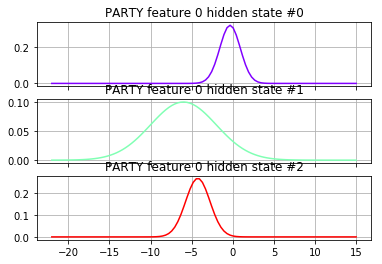

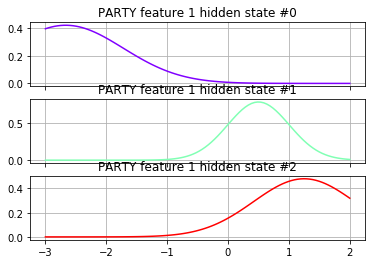

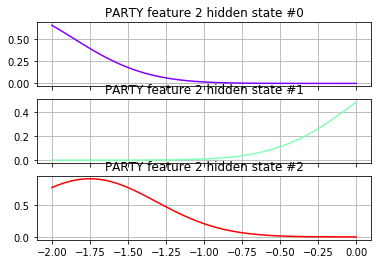

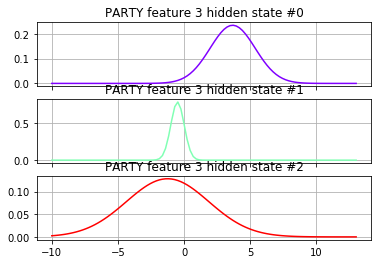

In [93]:
import math
from matplotlib import (cm, pyplot as plt, mlab)

def visualize(word, model):
    """ visualize the input model for a particular word """
    variance=np.array([np.diag(model.covars_[i]) for i in range(model.n_components)])
    figures = []
    for parm_idx in range(len(model.means_[0])):
        xmin = int(min(model.means_[:,parm_idx]) - max(variance[:,parm_idx]))
        xmax = int(max(model.means_[:,parm_idx]) + max(variance[:,parm_idx]))
        fig, axs = plt.subplots(model.n_components, sharex=True, sharey=False)
        colours = cm.rainbow(np.linspace(0, 1, model.n_components))
        for i, (ax, colour) in enumerate(zip(axs, colours)):
            x = np.linspace(xmin, xmax, 100)
            mu = model.means_[i,parm_idx]
            sigma = math.sqrt(np.diag(model.covars_[i])[parm_idx])
            ax.plot(x, mlab.normpdf(x, mu, sigma), c=colour)
            ax.set_title("{} feature {} hidden state #{}".format(word, parm_idx, i))

            ax.grid(True)
        figures.append(plt)
    for p in figures:
        p.show()
        
visualize(my_testword, model)

#####  ModelSelector class
Review the `ModelSelector` class from the codebase found in the `my_model_selectors.py` module.  It is designed to be a strategy pattern for choosing different model selectors.  For the project submission in this section, subclass `SelectorModel` to implement the following model selectors.  In other words, you will write your own classes/functions in the `my_model_selectors.py` module and run them from this notebook:

- `SelectorCV `: Log likelihood with CV
- `SelectorBIC`: BIC 
- `SelectorDIC`: DIC

You will train each word in the training set with a range of values for the number of hidden states, and then score these alternatives with the model selector, choosing the "best" according to each strategy. The simple case of training with a constant value for `n_components` can be called using the provided `SelectorConstant` subclass as follow:

In [94]:
from my_model_selectors import SelectorConstant

training = asl.build_training(features_ground)  # Experiment here with different feature sets defined in part 1
word = 'VEGETABLE' # Experiment here with different words
model = SelectorConstant(training.get_all_sequences(), training.get_all_Xlengths(), word, n_constant=3).select()
print("Number of states trained in model for {} is {}".format(word, model.n_components))

Number of states trained in model for VEGETABLE is 3


##### Cross-validation folds
If we simply score the model with the Log Likelihood calculated from the feature sequences it has been trained on, we should expect that more complex models will have higher likelihoods. However, that doesn't tell us which would have a better likelihood score on unseen data.  The model will likely be overfit as complexity is added.  To estimate which topology model is better using only the training data, we can compare scores using cross-validation.  One technique for cross-validation is to break the training set into "folds" and rotate which fold is left out of training.  The "left out" fold scored.  This gives us a proxy method of finding the best model to use on "unseen data". In the following example, a set of word sequences is broken into three folds using the [scikit-learn Kfold](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) class object. When you implement `SelectorCV`, you will use this technique.

In [95]:
from sklearn.model_selection import KFold

training = asl.build_training(features_ground) # Experiment here with different feature sets
word = 'VEGETABLE' # Experiment here with different words
word_sequences = training.get_word_sequences(word)
split_method = KFold()
for cv_train_idx, cv_test_idx in split_method.split(word_sequences):
    print("Train fold indices:{} Test fold indices:{}".format(cv_train_idx, cv_test_idx))  # view indices of the folds

Train fold indices:[2 3 4 5] Test fold indices:[0 1]
Train fold indices:[0 1 4 5] Test fold indices:[2 3]
Train fold indices:[0 1 2 3] Test fold indices:[4 5]


**Tip:** In order to run `hmmlearn` training using the X,lengths tuples on the new folds, subsets must be combined based on the indices given for the folds.  A helper utility has been provided in the `asl_utils` module named `combine_sequences` for this purpose.

##### Scoring models with other criterion
Scoring model topologies with **BIC** balances fit and complexity within the training set for each word.  In the BIC equation, a penalty term penalizes complexity to avoid overfitting, so that it is not necessary to also use cross-validation in the selection process.  There are a number of references on the internet for this criterion.  These [slides](http://www2.imm.dtu.dk/courses/02433/doc/ch6_slides.pdf) include a formula you may find helpful for your implementation.

The advantages of scoring model topologies with **DIC** over BIC are presented by Alain Biem in this [reference](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.58.6208&rep=rep1&type=pdf) (also found [here](https://pdfs.semanticscholar.org/ed3d/7c4a5f607201f3848d4c02dd9ba17c791fc2.pdf)).  DIC scores the discriminant ability of a training set for one word against competing words.  Instead of a penalty term for complexity, it provides a penalty if model liklihoods for non-matching words are too similar to model likelihoods for the correct word in the word set.

<a id='part2_submission'></a>
### Model Selection Implementation Submission
Implement `SelectorCV`, `SelectorBIC`, and `SelectorDIC` classes in the `my_model_selectors.py` module.  Run the selectors on the following five words. Then answer the questions about your results.

**Tip:** The `hmmlearn` library may not be able to train or score all models.  Implement try/except contructs as necessary to eliminate non-viable models from consideration.

In [96]:
words_to_train = ['FISH', 'BOOK', 'VEGETABLE', 'FUTURE', 'JOHN']
import timeit

In [97]:
# autoreload for automatically reloading changes made in my_model_selectors and my_recognizer
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [98]:
from my_model_selectors import SelectorCV

for set_name, features in feature_sets.items():
    training = asl.build_training(features)  # Experimentinggggg
    sequences = training.get_all_sequences()
    Xlengths = training.get_all_Xlengths()
    print("{} results:".format(set_name))
    for word in words_to_train:
        start = timeit.default_timer()
        model = SelectorCV(sequences, Xlengths, word, 
                        min_n_components=2, max_n_components=15, random_state = 14).select()
        end = timeit.default_timer()-start
        if model is not None:
            print("\tTraining complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
        else:
            print("\tTraining failed for {}".format(word))

features-ground results:
	Training complete for FISH with 2 states with time 0.27568452099512797 seconds
	Training complete for BOOK with 9 states with time 1.5594778349986882 seconds
	Training complete for VEGETABLE with 2 states with time 0.8218844919974799 seconds
	Training complete for FUTURE with 9 states with time 1.5750461770003312 seconds
	Training complete for JOHN with 15 states with time 19.04877387200395 seconds
features-norm results:
	Training complete for FISH with 2 states with time 0.2598348149986123 seconds
	Training complete for BOOK with 5 states with time 1.8395203950058203 seconds
	Training complete for VEGETABLE with 2 states with time 0.7306796679986292 seconds
	Training complete for FUTURE with 10 states with time 1.5225987310041091 seconds
	Training complete for JOHN with 14 states with time 21.722352173004765 seconds
features-polar results:
	Training complete for FISH with 2 states with time 0.24976156699995045 seconds
	Training complete for BOOK with 14 state

In [99]:
from my_model_selectors import SelectorBIC

for set_name, features in feature_sets.items():
    training = asl.build_training(features)  # Experimentingggg
    sequences = training.get_all_sequences()
    Xlengths = training.get_all_Xlengths()
    print("{} results:".format(set_name))
    for word in words_to_train:
        start = timeit.default_timer()
        model = SelectorBIC(sequences, Xlengths, word, 
                        min_n_components=2, max_n_components=15, random_state = 14).select()
        end = timeit.default_timer()-start
        if model is not None:
            print("\tTraining complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
        else:
            print("\tTraining failed for {}".format(word))

features-ground results:
	Training complete for FISH with 5 states with time 0.47430312399956165 seconds
	Training complete for BOOK with 12 states with time 2.6728087139999843 seconds
	Training complete for VEGETABLE with 15 states with time 1.045239473998663 seconds
	Training complete for FUTURE with 14 states with time 3.0995722459992976 seconds
	Training complete for JOHN with 14 states with time 28.57651628000167 seconds
features-norm results:
	Training complete for FISH with 3 states with time 0.4707431839997298 seconds
	Training complete for BOOK with 14 states with time 2.553095631003089 seconds
	Training complete for VEGETABLE with 7 states with time 1.0424435659951996 seconds
	Training complete for FUTURE with 14 states with time 2.888192035999964 seconds
	Training complete for JOHN with 15 states with time 25.285156227000698 seconds
features-polar results:
	Training complete for FISH with 6 states with time 0.495126091002021 seconds
	Training complete for BOOK with 12 states

In [100]:
from my_model_selectors import SelectorDIC

for set_name, features in feature_sets.items():
    training = asl.build_training(features_ground)  # Experimentingggg
    sequences = training.get_all_sequences()
    Xlengths = training.get_all_Xlengths()
    print("{} results:".format(set_name))
    for word in words_to_train:
        start = timeit.default_timer()
        model = SelectorDIC(sequences, Xlengths, word, 
                        min_n_components=2, max_n_components=15, random_state = 14).select()
        end = timeit.default_timer()-start
        if model is not None:
            print("\tTraining complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
        else:
            print("\tTraining failed for {}".format(word))

features-ground results:
	Training complete for FISH with 3 states with time 1.0208398579998175 seconds
	Training complete for BOOK with 15 states with time 5.246559614002763 seconds
	Training complete for VEGETABLE with 15 states with time 4.3253500840000925 seconds
	Training complete for FUTURE with 15 states with time 5.380231700000877 seconds
	Training complete for JOHN with 15 states with time 31.214760221999313 seconds
features-norm results:
	Training complete for FISH with 3 states with time 1.079755496000871 seconds
	Training complete for BOOK with 15 states with time 5.573418659994786 seconds
	Training complete for VEGETABLE with 15 states with time 4.366080568994221 seconds
	Training complete for FUTURE with 15 states with time 5.58522384299431 seconds
	Training complete for JOHN with 15 states with time 31.786886517998937 seconds
features-polar results:
	Training complete for FISH with 3 states with time 1.091067668996402 seconds
	Training complete for BOOK with 15 states wi

**Question 2:**  Compare and contrast the possible advantages and disadvantages of the various model selectors implemented.

**Answer 2:** 

## CV
#### Pros:
* Alternates data points between training and testing, resulting in a reduction of the variance with additional ''folds''
* Alternating allows for the model to be tested against unseen data.

#### Cons:
* Training is re-run from the beginning for each evaluated state, requiring additional computation and overhead.

----------------------------------

## BIC
#### Pros:
* Includes `d * log(N)` as a factor to penalize over-complexity of a model, where `d` measures the number of parameters/features
* Able to measure efficacy of parameters relative to their accuracy at predicting data

#### Cons:
* Includes `d * log(N)`, which leads to invalidating approximations with limited sample sizes more easily for increases in `d`

----------------------------------

## DIC
#### Pros:
* Calculations can easily be made from samples generated by Markov chain Monte Carlo simulations

#### Cons:
* Models with many parameters may not be penalized, depending on fit
* Has a tendency towards overfitting due to one pool of observation data being utilized for both posterior distributions and prediction models

<a id='part2_test'></a>
### Model Selector Unit Testing
Run the following unit tests as a sanity check on the implemented model selectors.  The test simply looks for valid interfaces  but is not exhaustive. However, the project should not be submitted if these tests don't pass.

In [101]:
from asl_test_model_selectors import TestSelectors
suite = unittest.TestLoader().loadTestsFromModule(TestSelectors())
unittest.TextTestRunner().run(suite)

....
----------------------------------------------------------------------
Ran 4 tests in 36.599s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

<a id='part3_tutorial'></a>
## PART 3: Recognizer
The objective of this section is to "put it all together".  Using the four feature sets created and the three model selectors, you will experiment with the models and present your results.  Instead of training only five specific words as in the previous section, train the entire set with a feature set and model selector strategy.  
### Recognizer Tutorial
##### Train the full training set
The following example trains the entire set with the example `features_ground` and `SelectorConstant` features and model selector.  Use this pattern for you experimentation and final submission cells.



In [102]:
from my_model_selectors import SelectorConstant

def train_all_words(features, model_selector):
    training = asl.build_training(features)  # Experiment here with different feature sets defined in part 1
    sequences = training.get_all_sequences()
    Xlengths = training.get_all_Xlengths()
    model_dict = {}
    for word in training.words:
        model = model_selector(sequences, Xlengths, word, 
                        n_constant=3).select()
        model_dict[word]=model
    return model_dict

models = train_all_words(features_ground, SelectorConstant)
print("Number of word models returned = {}".format(len(models)))

Number of word models returned = 112


##### Load the test set
The `build_test` method in `ASLdb` is similar to the `build_training` method already presented, but there are a few differences:
- the object is type `SinglesData` 
- the internal dictionary keys are the index of the test word rather than the word itself
- the getter methods are `get_all_sequences`, `get_all_Xlengths`, `get_item_sequences` and `get_item_Xlengths`

In [103]:
test_set = asl.build_test(features_ground)
print("Number of test set items: {}".format(test_set.num_items))
print("Number of test set sentences: {}".format(len(test_set.sentences_index)))

Number of test set items: 178
Number of test set sentences: 40


<a id='part3_submission'></a>
### Recognizer Implementation Submission
For the final project submission, students must implement a recognizer following guidance in the `my_recognizer.py` module.  Experiment with the four feature sets and the three model selection methods (that's 12 possible combinations). You can add and remove cells for experimentation or run the recognizers locally in some other way during your experiments, but retain the results for your discussion.  For submission, you will provide code cells of **only three** interesting combinations for your discussion (see questions below). At least one of these should produce a word error rate of less than 60%, i.e. WER < 0.60 . 

**Tip:** The hmmlearn library may not be able to train or score all models.  Implement try/except contructs as necessary to eliminate non-viable models from consideration.

In [104]:
from my_recognizer import recognize
from asl_utils import show_errors

In [105]:
print(feature_sets.keys())

dict_keys(['features-ground', 'features-norm', 'features-polar', 'features-delta', 'features-custom'])


In [106]:
# TODO Choose a feature set and model selector
ft_set_name = 'features-ground'
features =  feature_sets[ft_set_name]
model_selector = SelectorCV

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
print("{}\n{}: {}".format(model_selector, ft_set_name, feature_sets[ft_set_name]))
show_errors(guesses, test_set)

<class 'my_model_selectors.SelectorCV'>
features-ground: {'grnd-ry', 'grnd-rx', 'grnd-ly', 'grnd-lx'}

**** WER = 0.5955056179775281
Total correct: 72 out of 178
Video  Recognized                                                    Correct
    2: JOHN *ARRIVE *ARRIVE                                          JOHN WRITE HOMEWORK
    7: JOHN *PEOPLE GO *BOX                                          JOHN CAN GO CAN
   12: JOHN *WHAT *WHAT CAN                                          JOHN CAN GO CAN
   21: JOHN *VIDEOTAPE *JOHN *FUTURE *CAR *CAR *CHICAGO *FUTURE      JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: JOHN *JOHN *LOVE IX IX                                        JOHN LIKE IX IX IX
   28: JOHN *JOHN IX IX IX                                           JOHN LIKE IX IX IX
   30: JOHN *MARY *MARY *MARY *TOY1                                  JOHN LIKE IX IX IX
   36: MARY VEGETABLE *YESTERDAY *GO *MARY *IX                       MARY VEGETABLE KNOW IX LIKE CORN1
   40: JOHN IX *VISIT *IX *

In [107]:
# TODO Choose a feature set and model selector
ft_set_name = 'features-polar'
features =  feature_sets[ft_set_name]
model_selector = SelectorBIC

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
print("{}\n{}: {}".format(model_selector, ft_set_name, feature_sets[ft_set_name]))
show_errors(guesses, test_set)

<class 'my_model_selectors.SelectorBIC'>
features-polar: ['polar-rr', 'polar-rtheta', 'polar-lr', 'polar-ltheta']

**** WER = 0.5561797752808989
Total correct: 79 out of 178
Video  Recognized                                                    Correct
    2: JOHN *VIDEOTAPE *GIVE1                                        JOHN WRITE HOMEWORK
    7: JOHN CAN GO CAN                                               JOHN CAN GO CAN
   12: JOHN *WHAT *JOHN CAN                                          JOHN CAN GO CAN
   21: JOHN *NEW WONT *PREFER *GIVE1 *WHAT *FUTURE *WHO              JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: JOHN *IX IX *WHO IX                                           JOHN LIKE IX IX IX
   28: JOHN *FUTURE IX *FUTURE *LOVE                                 JOHN LIKE IX IX IX
   30: JOHN LIKE *MARY *MARY *MARY                                   JOHN LIKE IX IX IX
   36: *IX *VISIT *GIVE *GIVE *MARY *MARY                            MARY VEGETABLE KNOW IX LIKE CORN1
   40: JOHN *GO

In [108]:
# TODO Choose a feature set and model selector
ft_set_name = 'features-polar'
features =  feature_sets[ft_set_name]
model_selector = SelectorDIC

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
print("{}\n{}: {}".format(model_selector, ft_set_name, feature_sets[ft_set_name]))
show_errors(guesses, test_set)

<class 'my_model_selectors.SelectorDIC'>
features-polar: ['polar-rr', 'polar-rtheta', 'polar-lr', 'polar-ltheta']

**** WER = 0.5449438202247191
Total correct: 81 out of 178
Video  Recognized                                                    Correct
    2: JOHN *NEW *GIVE1                                              JOHN WRITE HOMEWORK
    7: JOHN CAN GO CAN                                               JOHN CAN GO CAN
   12: JOHN *WHAT *JOHN CAN                                          JOHN CAN GO CAN
   21: JOHN *NEW *JOHN *PREFER *GIVE1 *WHAT *FUTURE *WHO             JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: JOHN *IX IX *WHO IX                                           JOHN LIKE IX IX IX
   28: JOHN *FUTURE IX *FUTURE *LOVE                                 JOHN LIKE IX IX IX
   30: JOHN LIKE *MARY *MARY *MARY                                   JOHN LIKE IX IX IX
   36: *IX *VISIT *GIVE *GIVE *MARY *MARY                            MARY VEGETABLE KNOW IX LIKE CORN1
   40: JOHN *GO

**Question 3:**  Summarize the error results from three combinations of features and model selectors.  What was the "best" combination and why?  What additional information might we use to improve our WER?  For more insight on improving WER, take a look at the introduction to Part 4.

**Answer 3:**

Per my understanding of the question, I solely included results from combinations of our three selectors (SelectorCV, SelectorBIC, SelectorDIC) with the given four lists of features (ground, normal, polar, and delta) for my submission.
 
After testing all 12 combinations, the WER score of `SelectorDIC` with `features_polar` was the lowest amongst all
of the resultant WER scores at `0.54`. `SelectorBIC` had the second highest resultant WER score of `0.56` with the
same set of features. With looking at the advantages and disadvantages of each model, one of the cons of DIC is its tendency towards overfitting. That being the case, with a limited dataset, DIC's overfitting would benefit while BIC and Selection Cross Verification would, comparatively, be penalized. `SelectorCV`'s personal best was with `features_ground` (managing ~`0.59`, as seen above), further emphasizing the limitations of BIC and itself given a limited dataset.

As proven during informal experimentation, the WER score could be improved dramatically by utilizing a feature set with more than four parameters. With my initial understanding, I included parameters normalizing the polar coordinates, grounded features, and delta features for each of the models -- each of them managed WER scores < `0.60`. This, along with a larger dataset, could improve WER scores dramatically. Additionally, the context of words can be included by utilizing  Statistical Language Models (SLMs).

<a id='part3_test'></a>
### Recognizer Unit Tests
Run the following unit tests as a sanity check on the defined recognizer.  The test simply looks for some valid values but is not exhaustive. However, the project should not be submitted if these tests don't pass.

In [109]:
from asl_test_recognizer import TestRecognize
suite = unittest.TestLoader().loadTestsFromModule(TestRecognize())
unittest.TextTestRunner().run(suite)

..
----------------------------------------------------------------------
Ran 2 tests in 32.294s

OK


<unittest.runner.TextTestResult run=2 errors=0 failures=0>

In [110]:
# TODO Choose a feature set and model selector
ft_set_name = 'features-ground'
features =  feature_sets[ft_set_name]
model_selector = SelectorDIC # change as needed

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
print("{}\n{}: {}".format(model_selector, ft_set_name, feature_sets[ft_set_name]))
show_errors(guesses, test_set)

<class 'my_model_selectors.SelectorDIC'>
features-ground: {'grnd-ry', 'grnd-rx', 'grnd-ly', 'grnd-lx'}

**** WER = 0.5730337078651685
Total correct: 76 out of 178
Video  Recognized                                                    Correct
    2: JOHN *NEW *GIVE1                                              JOHN WRITE HOMEWORK
    7: *SOMETHING-ONE *CAR *ARRIVE *ARRIVE                           JOHN CAN GO CAN
   12: *IX *WHAT *WHAT *CAR                                          JOHN CAN GO CAN
   21: JOHN *GIVE1 *JOHN *FUTURE *CAR *CAR *FUTURE *MARY             JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: JOHN *IX IX *WHO IX                                           JOHN LIKE IX IX IX
   28: JOHN *WHO IX IX *LOVE                                         JOHN LIKE IX IX IX
   30: JOHN *MARY *MARY *MARY *MARY                                  JOHN LIKE IX IX IX
   36: *VISIT *VISIT *GIVE *GO *MARY *IX                             MARY VEGETABLE KNOW IX LIKE CORN1
   40: *MARY *GO *GIVE MAR

In [111]:
# TODO Choose a feature set and model selector
# NOTE SelectorBIC + polar < 60 WER
ft_set_name = 'features-ground'
features =  feature_sets[ft_set_name]
model_selector = SelectorBIC

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
print("{}\n{}: {}".format(model_selector, ft_set_name, feature_sets[ft_set_name])) 
show_errors(guesses, test_set)

<class 'my_model_selectors.SelectorBIC'>
features-ground: {'grnd-ry', 'grnd-rx', 'grnd-ly', 'grnd-lx'}

**** WER = 0.5730337078651685
Total correct: 76 out of 178
Video  Recognized                                                    Correct
    2: JOHN *NEW *GIVE1                                              JOHN WRITE HOMEWORK
    7: *SOMETHING-ONE *BOX *ARRIVE *WHAT                             JOHN CAN GO CAN
   12: *IX *WHAT *WHAT *CAR                                          JOHN CAN GO CAN
   21: JOHN *GIVE1 *JOHN *FUTURE *CAR *CAR *FUTURE *MARY             JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: JOHN *IX IX *WHO IX                                           JOHN LIKE IX IX IX
   28: JOHN *WHO IX *FUTURE *LOVE                                    JOHN LIKE IX IX IX
   30: JOHN *MARY *MARY *MARY *MARY                                  JOHN LIKE IX IX IX
   36: *VISIT *VISIT *IX *GO *MARY *IX                               MARY VEGETABLE KNOW IX LIKE CORN1
   40: *MARY *GO *GIVE MAR

In [112]:
# TODO Choose a feature set and model selector
ft_set_name = 'features-norm'
features =  feature_sets[ft_set_name]
model_selector = SelectorCV

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
print("{}\n{}: {}".format(model_selector, ft_set_name, feature_sets[ft_set_name]))
show_errors(guesses, test_set)

<class 'my_model_selectors.SelectorCV'>
features-norm: ['norm-rx', 'norm-ry', 'norm-lx', 'norm-ly']

**** WER = 0.651685393258427
Total correct: 62 out of 178
Video  Recognized                                                    Correct
    2: JOHN WRITE *ARRIVE                                            JOHN WRITE HOMEWORK
    7: JOHN *PEOPLE GO CAN                                           JOHN CAN GO CAN
   12: *LOVE *CAR *CAR CAN                                           JOHN CAN GO CAN
   21: *LIKE *JOHN *HAVE *GO *CAR *CAR *FUTURE *HAVE                 JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: *ANN LIKE *GO *LIKE *JOHN                                     JOHN LIKE IX IX IX
   28: *ANN LIKE *LIKE *LIKE IX                                      JOHN LIKE IX IX IX
   30: *SHOOT LIKE *MARY *LIKE IX                                    JOHN LIKE IX IX IX
   36: MARY *SHOULD *GIVE1 *GO LIKE *IX                              MARY VEGETABLE KNOW IX LIKE CORN1
   40: JOHN *VISIT *YESTERDAY 

In [113]:
# TODO Choose a feature set and model selector
ft_set_name = 'features-norm'
features =  feature_sets[ft_set_name]
model_selector = SelectorDIC

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
print("{}\n{}: {}".format(model_selector, ft_set_name, feature_sets[ft_set_name]))
show_errors(guesses, test_set)

<class 'my_model_selectors.SelectorDIC'>
features-norm: ['norm-rx', 'norm-ry', 'norm-lx', 'norm-ly']

**** WER = 0.5955056179775281
Total correct: 72 out of 178
Video  Recognized                                                    Correct
    2: JOHN WRITE *ARRIVE                                            JOHN WRITE HOMEWORK
    7: *MARY *CAR GO CAN                                             JOHN CAN GO CAN
   12: JOHN *WHAT *ARRIVE CAN                                        JOHN CAN GO CAN
   21: *MARY *JOHN *JOHN *BLAME *CAR *CAR *FUTURE CHICKEN            JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: JOHN LIKE IX *LIKE IX                                         JOHN LIKE IX IX IX
   28: *ANN *ANN IX *MARY IX                                         JOHN LIKE IX IX IX
   30: *IX-1P *CHOCOLATE *MARY *LOVE *LOVE                           JOHN LIKE IX IX IX
   36: MARY *MARY *YESTERDAY *SHOOT LIKE *IX                         MARY VEGETABLE KNOW IX LIKE CORN1
   40: *MARY *JOHN *FUTURE1 

In [114]:
# TODO Choose a feature set and model selector
ft_set_name = 'features-norm'
features =  feature_sets[ft_set_name]
model_selector = SelectorBIC

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
print("{}\n{}: {}".format(model_selector, ft_set_name, feature_sets[ft_set_name]))
show_errors(guesses, test_set)

<class 'my_model_selectors.SelectorBIC'>
features-norm: ['norm-rx', 'norm-ry', 'norm-lx', 'norm-ly']

**** WER = 0.6067415730337079
Total correct: 70 out of 178
Video  Recognized                                                    Correct
    2: JOHN WRITE *ARRIVE                                            JOHN WRITE HOMEWORK
    7: *MARY *NEW GO *WHAT                                           JOHN CAN GO CAN
   12: JOHN *WHAT *WHAT CAN                                          JOHN CAN GO CAN
   21: *MARY *NEW *JOHN *BLAME *CAR *CAR *CHICKEN CHICKEN            JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: JOHN LIKE IX *MARY IX                                         JOHN LIKE IX IX IX
   28: *ANN *ANN *ANN *ANN *ANN                                      JOHN LIKE IX IX IX
   30: *IX-1P *IX *MARY IX IX                                        JOHN LIKE IX IX IX
   36: MARY *MARY *GIVE3 *SHOOT LIKE *IX                             MARY VEGETABLE KNOW IX LIKE CORN1
   40: *MARY *JOHN *FUTURE1 

In [115]:
# TODO Choose a feature set and model selector
ft_set_name = 'features-polar'
features =  feature_sets[ft_set_name]
model_selector = SelectorCV

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
print("{}\n{}: {}".format(model_selector, ft_set_name, feature_sets[ft_set_name]))
show_errors(guesses, test_set)

<class 'my_model_selectors.SelectorCV'>
features-polar: ['polar-rr', 'polar-rtheta', 'polar-lr', 'polar-ltheta']

**** WER = 0.6067415730337079
Total correct: 70 out of 178
Video  Recognized                                                    Correct
    2: *POSS *BROTHER *ARRIVE                                        JOHN WRITE HOMEWORK
    7: JOHN CAN GO CAN                                               JOHN CAN GO CAN
   12: JOHN *WHAT *GIVE1 CAN                                         JOHN CAN GO CAN
   21: JOHN *JOHN WONT *WHO *CAR *CAR *FUTURE *WHO                   JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: *MARY *MARY *MARY *MARY IX                                    JOHN LIKE IX IX IX
   28: JOHN *MARY *MARY *MARY *LOVE                                  JOHN LIKE IX IX IX
   30: JOHN *MARY *MARY *MARY *GO                                    JOHN LIKE IX IX IX
   36: MARY VEGETABLE *GIRL *GIVE *MARY *MARY                        MARY VEGETABLE KNOW IX LIKE CORN1
   40: JOHN IX *

In [116]:
# TODO Choose a feature set and model selector
ft_set_name = 'features-delta'
features =  feature_sets[ft_set_name]
model_selector = SelectorCV

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
print("{}\n{}: {}".format(model_selector, ft_set_name, feature_sets[ft_set_name]))
show_errors(guesses, test_set)

<class 'my_model_selectors.SelectorCV'>
features-delta: ['delta-rx', 'delta-ry', 'delta-lx', 'delta-ly']

**** WER = 0.6460674157303371
Total correct: 63 out of 178
Video  Recognized                                                    Correct
    2: JOHN *IX *ARRIVE                                              JOHN WRITE HOMEWORK
    7: JOHN *DECIDE *MARY *TEACHER                                   JOHN CAN GO CAN
   12: JOHN *BOX *WHO CAN                                            JOHN CAN GO CAN
   21: *MARY *MARY *LOVE *MARY *STUDENT *ARRIVE *WHAT *MARY          JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: JOHN *IX *MARY IX IX                                          JOHN LIKE IX IX IX
   28: JOHN *IX IX IX IX                                             JOHN LIKE IX IX IX
   30: JOHN *IX IX *JOHN IX                                          JOHN LIKE IX IX IX
   36: *IX *IX *JOHN IX *MARY *IX                                    MARY VEGETABLE KNOW IX LIKE CORN1
   40: *MARY IX *JOHN *I

In [117]:
# TODO Choose a feature set and model selector
ft_set_name = 'features-delta'
features =  feature_sets[ft_set_name]
model_selector = SelectorDIC

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
print("{}\n{}: {}".format(model_selector, ft_set_name, feature_sets[ft_set_name]))
show_errors(guesses, test_set)

<class 'my_model_selectors.SelectorDIC'>
features-delta: ['delta-rx', 'delta-ry', 'delta-lx', 'delta-ly']

**** WER = 0.6292134831460674
Total correct: 66 out of 178
Video  Recognized                                                    Correct
    2: JOHN *GIVE1 *ARRIVE                                           JOHN WRITE HOMEWORK
    7: JOHN *GIVE1 *GIVE1 *ARRIVE                                    JOHN CAN GO CAN
   12: JOHN *BOX *JOHN CAN                                           JOHN CAN GO CAN
   21: JOHN *MARY *LOVE *MARY *HOUSE *FUTURE *FUTURE *MARY           JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: JOHN *IX *JOHN IX IX                                          JOHN LIKE IX IX IX
   28: JOHN *MARY *JOHN IX *SHOULD                                   JOHN LIKE IX IX IX
   30: JOHN *IX *SHOULD *JOHN IX                                     JOHN LIKE IX IX IX
   36: *JOHN *JOHN *JOHN IX *MARY *MARY                              MARY VEGETABLE KNOW IX LIKE CORN1
   40: *MARY IX *JOHN M

In [118]:
# TODO Choose a feature set and model selector
ft_set_name = 'features-delta'
features =  feature_sets[ft_set_name]
model_selector = SelectorBIC

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
print("{}\n{}: {}".format(model_selector, ft_set_name, feature_sets[ft_set_name]))
show_errors(guesses, test_set)

<class 'my_model_selectors.SelectorBIC'>
features-delta: ['delta-rx', 'delta-ry', 'delta-lx', 'delta-ly']

**** WER = 0.6292134831460674
Total correct: 66 out of 178
Video  Recognized                                                    Correct
    2: JOHN *GIVE1 *ARRIVE                                           JOHN WRITE HOMEWORK
    7: JOHN *BOX *GIVE1 *ARRIVE                                      JOHN CAN GO CAN
   12: JOHN *BOX *JOHN CAN                                           JOHN CAN GO CAN
   21: JOHN *MARY *LOVE *MARY *BUY *FUTURE *FUTURE *MARY             JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: JOHN *IX *JOHN IX IX                                          JOHN LIKE IX IX IX
   28: JOHN *MARY *JOHN IX *SHOULD                                   JOHN LIKE IX IX IX
   30: JOHN *IX *SHOULD *JOHN IX                                     JOHN LIKE IX IX IX
   36: *JOHN *JOHN *JOHN IX *MARY *MARY                              MARY VEGETABLE KNOW IX LIKE CORN1
   40: *MARY IX *JOHN M

<a id='part4_info'></a>
## PART 4: (OPTIONAL)  Improve the WER with Language Models
We've squeezed just about as much as we can out of the model and still only get about 50% of the words right! Surely we can do better than that.  Probability to the rescue again in the form of [statistical language models (SLM)](https://en.wikipedia.org/wiki/Language_model).  The basic idea is that each word has some probability of occurrence within the set, and some probability that it is adjacent to specific other words. We can use that additional information to make better choices.

##### Additional reading and resources
- [Introduction to N-grams (Stanford Jurafsky slides)](https://web.stanford.edu/class/cs124/lec/languagemodeling.pdf)
- [Speech Recognition Techniques for a Sign Language Recognition System, Philippe Dreuw et al](https://www-i6.informatik.rwth-aachen.de/publications/download/154/Dreuw--2007.pdf) see the improved results of applying LM on *this* data!
- [SLM data for *this* ASL dataset](ftp://wasserstoff.informatik.rwth-aachen.de/pub/rwth-boston-104/lm/)

##### Optional challenge
The recognizer you implemented in Part 3 is equivalent to a "0-gram" SLM.  Improve the WER with the SLM data provided with the data set in the link above using "1-gram", "2-gram", and/or "3-gram" statistics. The `probabilities` data you've already calculated will be useful and can be turned into a pandas DataFrame if desired (see next cell).  
Good luck!  Share your results with the class!

In [119]:
# create a DataFrame of log likelihoods for the test word items
df_probs = pd.DataFrame(data=probabilities)
df_probs.head()

,ALL,ANN,APPLE,ARRIVE,BILL,BLAME,BLUE,BOOK,BORROW,BOX,...,VIDEOTAPE,VISIT,WANT,WHAT,WHO,WILL,WOMAN,WONT,WRITE,YESTERDAY
0,-99.172607,-inf,-11933.126564,-191.516277,-58981.226360,-222.176218,-1098.101084,-261.842629,-1190.290287,-252.812333,...,-314.786132,-109.966947,-11638.253775,-80.125609,-139.856733,-13388.666070,-68.198863,-1832.825434,-180.927036,-90.310925
1,-275.041058,-inf,-23669.472345,-168.615563,-38461.804608,-216.970315,-1104.552040,-202.006908,-1006.400779,-209.047863,...,-275.764059,-201.349387,-19430.745462,-139.274460,-203.075464,-10489.388717,-403.872679,-1742.427532,-275.965296,-147.956409
2,-443.203731,-inf,-38681.695580,-282.052302,-74060.190215,-407.436429,-1413.436814,-329.362033,-3057.811916,-403.520494,...,-483.637913,-448.531624,-38090.285873,-317.896054,-411.843842,-15221.634735,-576.963642,-2003.166517,-436.070651,-344.519151
3,-170.568302,-inf,-2450.207862,-195.361145,-6940.023356,-347.012200,-988.039902,-202.297093,-1588.049624,-341.136739,...,-269.051255,-61.258422,-6018.795545,-50.196011,-50.045010,-2713.504892,-170.955641,-1027.565911,-281.101077,-67.139108
4,-218.736386,-inf,-27211.854051,-90.162633,-176555.386006,-110.336591,-1540.067153,-95.484058,-392.422813,-79.526909,...,-409.317202,-123.149693,-17071.856586,-112.650258,-228.134206,-11720.773899,-312.563968,-2982.764414,-347.677422,-151.404873
